In [1]:
import nltk.translate.chrf_score
# Import libraries
import torch
import pathlib as pl
import random
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')

# del transformer
# torch.cuda.empty_cache()

In [2]:
# import pandas as pd

# def explore_tsv_structure(tsv_file):
#     df = pd.read_csv(tsv_file, sep='\t')
#     print("TSV file structure:")
#     print(df.head())
#     print("Columns:")
#     print(df.columns)
#     print("Number of rows:", len(df))

# tsv_file = "/kaggle/input/c4200m/C4_200M.tsv-00000-of-00010"
# explore_tsv_structure(tsv_file)

Grammar Error Correction with Transformers
======================================================

This notebook shows how to train a GEC model based on transformers and experiments with Transformer architecture in order to better understand how changes in the model architecture and in the training reflect in different performances.

## Table of Contents

- [1. Data Sourcing and Processing](#1)
    - Tokenizing and Embedding
    - Collation
- [2. Seq2Seq Network using Transformer](#2)
    - Positional encoding
    - Multi-head attention
- [3. Model definition](#3)
- [4. Training](#4)
- [5. Evaluation](#5)
    - Greedy Search Inference
    - Performance evaluation
- [6. Experiments](#6)
- [7. Results](#7)
- [8. References](#8)

<a name='1'></a>
# 1. Data Sourcing and Processing

C4 200M dataset from Google Research is used in this notebook. You can find more information about the C4 200M dataset on Google Research's [BEA 2021 paper](https://aclanthology.org/2021.bea-1.4/) (Stahlberg and Kumar, 2021).

The already [processed dataset](https://huggingface.co/datasets/liweili/c4_200m) was extracted from Huggingface in CSV format, then was transformed to HDF5 format for better manageability. The conversion process is detailed in ``utils.py``, and was based on this [notebook](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mechanics/custom-data-loader-csv.ipynb).
The final version of the dataset is uploaded on [Kaggle](https://www.kaggle.com/datasets/dariocioni/c4200m).

A custom class ``Hdf5Dataset`` based on ``torch.utils.data.Dataset`` is developed, which yields a pair of source-target raw sentences.

| source                                             | target                                                  |
|----------------------------------------------------|---------------------------------------------------------|
| Much many brands and sellers still in the market.  | Many brands and sellers still in the market.            |
| She likes playing in park and come here every week | She likes playing in the park and comes here every week |

To be able to train on a arbitrary subset of a single file, the dataset only reads chunks of length ``num_entries`` if the parameter is specified . In order to capture more examples, a different chunk can be randomly chosen at each epoch by specifying ``randomized=True``

In [2]:
import h5py
from torch.utils.data import Dataset
random.seed(42)

class Hdf5Dataset(Dataset):
    """Custom Dataset for loading entries from HDF5 databases"""

    def __init__(self, h5_path, transform=None,num_entries = None,randomized=False):

        self.h5f = h5py.File(h5_path, 'r')
        self.size = self.h5f['labels'].shape[0]
        self.transform = transform
        self.randomized = randomized
        self.max_index = num_entries if num_entries is not None else self.size
        #Chooses an offset for the dataset when using a subset of a Hdf5 file
        if randomized:
            self.offset = random.choice(range(0,self.size//self.max_index))*self.max_index
        else:
            self.offset = 0


    def __getitem__(self, index):
        if index > self.max_index:
            raise StopIteration
        input = self.h5f['input'][self.offset+index].decode('utf-8')
        label = self.h5f['labels'][self.offset+index].decode('utf-8')
        if self.transform is not None:
            features = self.transform(input)
        return input, label

    def __len__(self):
        return self.max_index

    def reshuffle(self):
        if self.randomized:
            self.offset = random.choice(range(0,self.size//self.max_index))*self.max_index
        else:
            print("Please set randomized=True")

In [3]:
from typing import List
from tqdm import tqdm
from torchtext.data import get_tokenizer

SRC_LANGUAGE = 'incorrect'
TGT_LANGUAGE = 'correct'
MAX_LENGTH = 500
VOCAB_SIZE = 50000 #20000

TRAIN_SAMPLES = 1000000
VALID_SAMPLES = 10000

# Place-holders
vocab_transform = {}

token_transform = get_tokenizer("basic_english")

#folder = 'dataset'
#train_filename = 'train.hf5'
#valid_filename = 'valid.hf5'
#test_filename = 'test.hf5'
#src_vocab_path = 'vocab/src_vocab_20K_spacy.pth'
#tgt_vocab_path = 'vocab/src_vocab_20K_spacy.pth'
#embedding_path = 'vocab/glove_42B_300d_20K.pth'
#checkpoint_folder = 'models'

# modify for each user's project dir structure. I like putting
# my data in a 'data' folder
data_dir = './data/'
vocab_dir = './vocab/'
# for now, using one file: in the future, use a few, put into a torch data loader,
# shuffle, and then take our training, validation, test samples
train_filename = f'{data_dir}C4_200M.hdf5-00000-of-00010'
valid_filename = train_filename
test_filename = train_filename
# embedding_path = '/content/drive/MyDrive/Colab Notebooks/GEC_Soft_Masked_BERT/vocab/glove_42B_300d_20K.pth'
src_vocab_path = f'{vocab_dir}vocab_50K.pth'
tgt_vocab_path = src_vocab_path # src and taget vocab are same
checkpoint_folder = data_dir

In [4]:
import torchtext as text
import numpy as np
import torch

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# # Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<UNK>','<PAD>', '<BOS>', '<EOS>']

vocab_transform[SRC_LANGUAGE] = torch.load(src_vocab_path)
vocab_transform[TGT_LANGUAGE] = torch.load(tgt_vocab_path)

#Procedure for pretrained embeddings. Not fitting into memory
# def pretrained_embs(name: str, dim: str,max_vectors: int=None):
#     glove_vectors = text.vocab.GloVe(name=name,dim=dim,max_vectors=max_vectors)
#     glove_vocab = text.vocab.vocab(glove_vectors.stoi)
#     pretrained_embeddings = glove_vectors.vectors
#     glove_vocab.insert_token('<UNK>',UNK_IDX)
#     pretrained_embeddings = torch.cat((torch.mean(pretrained_embeddings,dim=0,keepdims=True),pretrained_embeddings))
#     glove_vocab.insert_token('<PAD>',PAD_IDX)
#     pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
#     glove_vocab.insert_token('<BOS>',PAD_IDX)
#     pretrained_embeddings = torch.cat((torch.rand(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
#     glove_vocab.insert_token('<EOS>',PAD_IDX)
#     pretrained_embeddings = torch.cat((torch.rand(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
#     glove_vocab.set_default_index(UNK_IDX)
#     return glove_vocab,pretrained_embeddings
# vocab, embeddings = pretrained_embs('42B','100',50000)

### Collation

An iterator over ``Hdf5dataset`` yields a pair of raw strings.
We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network.
Below I defined a collate function that converts batch of raw strings into batch tensors that can be fed directly into the model.

In [5]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    #truncate sequences longer than MAX_LENGTH
    if(len(token_ids) > MAX_LENGTH - 2):
        token_ids = token_ids[0:MAX_LENGTH -2]
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform,
                                           vocab_transform[ln],
                                           tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Here's an example of the encoding of the source and target sentences

In [6]:
text = ('Data Maining is awesome!','Data Mining is awesome!')
src,tgt = collate_fn([text])
print(src,tgt)

tensor([[   2],
        [ 184],
        [   0],
        [  13],
        [1868],
        [  31],
        [   3]]) tensor([[   2],
        [ 184],
        [1838],
        [  13],
        [1868],
        [  31],
        [   3]])


<a name='2'></a>
# 2. Seq2Seq Network using Transformer

Transformer is a Seq2Seq model introduced in [“Attention is all you need”](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>) paper for solving machine translation tasks.
Below, we will create a Seq2Seq network that uses Transformer. The network consists of three parts:
1) The embedding layer. This layer converts tensor of input indices into corresponding tensor of input embeddings.
    These embedding are further augmented with ``Positional Encodings``, to provide position information of input tokens to the model.
2) The actual [Transformer](<https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>) model.
3) The output of Transformer model is finally passed through a linear layer that give un-normalized probabilities for each token in the target language.

### Positional Encoding
Differently from RNNs, Transformers don't have a notion of relative or absolute position of the tokens in the input.
One solution is to combine the input embeddings with positional embeddings, specific to each position in an input sequence.
A solution that is not biased towards the initial positions consists in a combination of sine and cosine functions of different frequencies ([Vaswani et al. ,2017](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>))

Given an embedding of length $d$, a position in the sequence $pos$ and the $i$-th dimension of the embedding, the position embedding is calculated as

$$PE_{(pos,2i)} = \sin(pos/10000^{2i/d})\quad,\quad PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d})$$

Dropout is also added to the sums of the embeddings and the positional encodings in both the encoder and decoder.

<img src="https://github.com/ciodar/GEC_Methods/blob/master/img/pos_enc.png?raw=true">

### Multi-head attention
A single transformer block cannot capture all the different kinds of simultaneous relations among its inputs.
To address this problem, Transformers can use multiple self-attention heads, residing in parallel layers and with different parameter sets.
Each head $i$ will have a different set of key, query and value matrices $W_i^K,W_i^Q,W_i^V$ and will project into different embeddings for each head.
The different embeddings are finally reduced to the original input dimension, using a trainable linear projection $W^O$

<img src="https://github.com/ciodar/GEC_Methods/blob/master/img/multihead.png?raw=true">




In [7]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer

import math
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size,embedding_weights=None):
        super(TokenEmbedding, self).__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights,freeze=True,padding_idx=PAD_IDX)
        else:
            self.embedding = nn.Embedding(vocab_size, emb_size)

            # self.embedding.weight.requires_grad =False
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 100,
                 dropout: float = 0.0,
                 embedding_weights = None):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size,embedding_weights)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size,embedding_weights)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
    
    def create_mask(src, tgt):
        src_seq_len = src.shape[0]
        tgt_seq_len = tgt.shape[0]

        def generate_square_subsequent_mask(sz):
            mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask
        
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
        src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

        src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

        return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    

    def encode(self, src: Tensor, src_mask: Tensor, src_padding_mask: Tensor = None):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask, src_padding_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Two different sets of masks are needed during training:
- A subsequent word mask that will prevent model to look into the future words when making predictions.
- A mask to hide source and target padding tokens and prevent to compute attention on them.

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, repeat_size=-1):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
        
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    
    if repeat_size != -1:
        tgt_mask = tgt_mask.repeat(repeat_size, 1, 1)
        src_mask = src_mask.repeat(repeat_size, 1, 1)
        tgt_padding_mask = tgt_padding_mask.repeat(repeat_size, 1, 1)
        src_padding_mask = src_padding_mask.repeat(repeat_size, 1, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

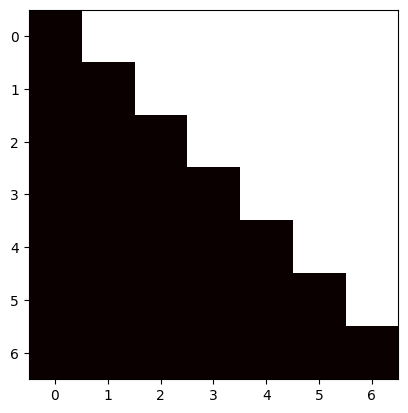

In [9]:
example_mask = create_mask(src,tgt)
_ = plt.imshow(example_mask[1].cpu(),cmap='hot')
plt.show()

<a name="3"></a>
# 3. Model definition
The network is instantiated as a  ``Seq2SeqTransformer`` object, where the following hyperparameters can be changed:
- Embedding Size
- Number of Transformer layers in the Encoder and Decoder
- Units in the Feed Forward Network
- Number of attention heads
- The dropout between each sublayer of the Transformer and in the sum of the embeddings with the positional encoding


In [10]:
torch.manual_seed(0)

VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE].vocab.itos_) # 50k
print(VOCAB_SIZE)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 1024
BATCH_SIZE = 24
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

#To save and retrieve checkpoints
model_name = 'transformer_%dE_%dH_%dF_%d_%d.pt'%(EMB_SIZE,NHEAD,FFN_HID_DIM,NUM_DECODER_LAYERS,NUM_DECODER_LAYERS)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, VOCAB_SIZE, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

#transformer = nn.DataParallel(transformer, device_ids=[0,1])
"""
https://stackoverflow.com/questions/70676122/when-training-in-transformer-with-multi-gpu-the-shape-of-mask-would-get-divided
"""
transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.1)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-8)

50000


In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import IterableDataset

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Hdf5Dataset(train_filename,num_entries=TRAIN_SAMPLES,randomized=True)
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)


        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Hdf5Dataset(valid_filename,num_entries=VALID_SAMPLES)
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            
        with torch.no_grad():
            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)


        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

<a name="4"></a>
# 4. Training
The training is performed on 20 epochs, and a checkpoint is saved at each epoch. The entire training process requires approximately 3 hours to complete on Kaggle.

I used the cross-entropy loss as the loss function and Adam optimizer for training.
The regularization hyperparameters were chosen as in ([Vaswani et al. ,2017](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>))

- learning rate = $10^{-5}$
- $\beta_1 = 0.9$
- $\beta_2 = 0.98$
- $\hat{\varepsilon} = 10^{-9}$

## Re-Training

New parameters:

- learning_rate = $10^{-3}$
- $\beta_1 = 0.9$
- $\beta_2 = 0.98$
- $\hat{\varepsilon} = 10^{-8}$

## Label Smoothing
Label smoothing is a regularization technique that introduces noise in the labels.
This way, we can avoid to obtain a model that is over-confident on certain tokens (ex. the UNK token), and give a lesser probability also on other tokens.

In [14]:
!gdown "1lMszd3vdpNytwx1pZt9sB2X5MCOK0CWc"

Downloading...
From (uriginal): https://drive.google.com/uc?id=1lMszd3vdpNytwx1pZt9sB2X5MCOK0CWc
From (redirected): https://drive.google.com/uc?id=1lMszd3vdpNytwx1pZt9sB2X5MCOK0CWc&confirm=t&uuid=b48387fc-0b07-4e18-9eb0-0a5bb53a0c6b
To: /home/seang/Dev/Git/NMA2023/Grammar-Error-Correction/various_transformer_models.tar.bz2
100%|██████████████████████████████████████| 2.81G/2.81G [00:35<00:00, 78.6MB/s]


In [12]:
latest_chekpt_file = f"{pl.Path(checkpoint_folder)}/transformer_1mil_train_512E_8H_1024F_6_6_30_epoch.pt"
checkpoint = torch.load(latest_chekpt_file)
transformer.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
print(epoch)

30


In [20]:
# from timeit import default_timer as timer
# NUM_EPOCHS = 5

# train_losses = []
# val_losses = []

# for epoch in range(NUM_EPOCHS+1, 8*NUM_EPOCHS+1):
#     start_time = timer()
#     train_loss = train_epoch(transformer, optimizer)
#     end_time = timer()
#     val_loss = evaluate(transformer)
#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': transformer.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': val_loss,
#     }, pl.Path(checkpoint_folder)/model_name)

Epoch: 6, Train loss: 2.447, Val loss: 2.440, Epoch time = 2859.175s
Epoch: 7, Train loss: 2.413, Val loss: 2.414, Epoch time = 2871.825s
Epoch: 8, Train loss: 2.395, Val loss: 2.393, Epoch time = 2865.124s
Epoch: 9, Train loss: 2.374, Val loss: 2.376, Epoch time = 2870.101s
Epoch: 10, Train loss: 2.364, Val loss: 2.357, Epoch time = 2862.738s
Epoch: 11, Train loss: 2.344, Val loss: 2.349, Epoch time = 2873.777s
Epoch: 12, Train loss: 2.342, Val loss: 2.350, Epoch time = 2880.635s
Epoch: 13, Train loss: 2.336, Val loss: 2.343, Epoch time = 2868.913s
Epoch: 14, Train loss: 2.330, Val loss: 2.336, Epoch time = 2862.909s
Epoch: 15, Train loss: 2.318, Val loss: 2.306, Epoch time = 2864.195s
Epoch: 16, Train loss: 2.310, Val loss: 2.308, Epoch time = 2849.523s
Epoch: 17, Train loss: 2.302, Val loss: 2.303, Epoch time = 2848.522s
Epoch: 18, Train loss: 2.284, Val loss: 2.301, Epoch time = 2852.933s
Epoch: 19, Train loss: 2.295, Val loss: 2.302, Epoch time = 2864.584s
Epoch: 20, Train loss: 2

KeyboardInterrupt: 

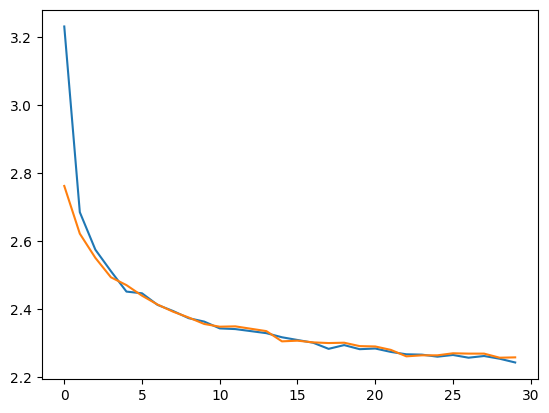

In [13]:
latest_checkpt_train_losses = [3.230, 2.685, 2.575, 2.512, 2.452, 2.447, 2.413, 2.395, 2.374, 2.364, 2.344, 2.342,\
                               2.336, 2.330, 2.318, 2.310, 2.302, 2.284, 2.295, \
                               2.283, 2.285, 2.275, 2.268, 2.267, 2.261, 2.266, \
                               2.258, 2.263, 2.255, 2.244]
latest_checkpt_val_losses = [2.762, 2.622, 2.551, 2.494, 2.471, 2.440, 2.414, 2.393, 2.376, 2.357, 2.349, 2.350, \
                             2.343, 2.336, 2.306, 2.308, 2.303, 2.301, 2.302, \
                             2.292, 2.291, 2.281, 2.262, 2.265, 2.265, 2.271, \
                             2.270, 2.270, 2.258, 2.259]
len(latest_checkpt_train_losses), len(latest_checkpt_val_losses)
_ = plt.plot(latest_checkpt_train_losses)
_ = plt.plot(latest_checkpt_val_losses)

<a name="5"></a>
# 5. Evaluation

## Greedy Search inference
We can perform corrections of sentences using the ``greedy_decode`` function.
In this function, at each timestep the most probable token is selected as correction at each time step, without evaluating its impact on the rest of the sequence.

I provide a batched implementation of greedy search for higher inference speed, based on a simplification of [HuggingFace Pytorch implementation](https://github.com/huggingface/transformers/blob/8f2723caf0f1bf7e1f639d28d004f81c96d19bbc/src/transformers/generation_utils.py) .
In this implementation, the model is forced to predict only PAD tokens after the character EOS is predicted, using the following formula:

$$\hat{y}_t = \hat{y}_t * u_t + (1-u_t) * \text{<PAD>}$$

where $\hat{y}_t$ is a vector containing the index of the highest probability word at time $t$ and $u_t$ is a boolean vector which is set to 1 if a EOS token is has not been predicted yet for the i-th sentence of the batch and 0 otherwise.
The prediction ends if $u_t[i] == 0 \; \forall  i$ or if the maximum sequence length is reached.

In [23]:
# function to generate output sequence using greedy algorithm
# input: (input_length,batch_size)
# output: (input_length)
def greedy_decode(model, src, src_mask, src_padding_mask, max_len):
    batch_size = src.shape[1]

    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = src_padding_mask.to(DEVICE)
    unfinished_sequences = torch.ones(1,batch_size).to(DEVICE)

    context = transformer.encode(src, src_mask,src_padding_mask).to(DEVICE)
    ys = torch.ones(1, batch_size).fill_(BOS_IDX).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, context, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob,dim=1)

        #Predict only PAD_IDX after EOS_IDX is predicted
        next_word = next_word * unfinished_sequences + (1-unfinished_sequences) * PAD_IDX
        ys = torch.cat([ys,
                        next_word], dim=0)

        # if eos_token was found in one sentence, set sentence to finished
        unfinished_sequences = unfinished_sequences.mul((next_word != EOS_IDX).long())

        # stop when each sentence is finished, or if we exceed the maximum length
        if unfinished_sequences.max() == 0:
            break
    return ys.int()


# actual function to correct input sentence
def correct(src_sentence: str, model: torch.nn.Module):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    src_padding_mask = (torch.zeros(1, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).flatten()
    return ' '.join([vocab_transform[SRC_LANGUAGE].vocab.itos_[i] for i in tgt_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])

A better way could be to use a ``Beam Search``, choosing $k$ tokens at each timestep and then scoring each node with its log probability.

In [19]:
# checkpoint = torch.load(pl.Path(checkpoint_folder)/model_name)
# transformer.load_state_dict(checkpoint['model_state_dict'])

transformer.eval()

# Pick one in 18M examples
test_iter = Hdf5Dataset(test_filename,num_entries=None)

src,trg = random.choice(test_iter)

print("input: \"",src,"\"")
print("target: \"",trg,"\"")

prediction = correct(src,transformer)

print("prediction: \"%s\""%prediction)

input: " Each teacher receives a report that shows his class’s performance in the topic tested. "
target: " Each teacher receives a report that shows their class’s performance across the topics tested. "
prediction: "each teacher receives a report that shows his <UNK> performance in the topic tested ."


## Performance evaluation
Performance is evaluated using the chrF score, which computes an F-score on character $n$-grams ([Popovi ́c, 2015](https://aclanthology.org/W15-3049/)).
The formula for the chrF score is

$$\text{chrF}_\beta = (1+ \beta^2) \frac{\text{chrP} \cdot \text{chrR}}{\beta^2 \cdot \text{chrP} + \text{chrR}}$$

where chrP and chrR are $n$-gram precision and recall averaged over all $n$-grams.

In the experiments I used character $n$-grams between 1 and 6 and $\beta=3$. White space between words is ignored during scoring.

In [33]:
from torch.utils.data import DataLoader
from nltk.translate import chrf_score,bleu_score
import re

def test_collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(tgt_sample.rstrip("\n"))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

def test_chrf(model):
    model.eval()
    score = 0

    test_iter = Hdf5Dataset(test_filename,num_entries=VALID_SAMPLES)
    test_dataloader = DataLoader(test_iter, batch_size=64,collate_fn=test_collate_fn)

    for src, tgt in test_dataloader:
        
        src_mask, _, src_padding_mask, _ = create_mask(src, src)
        num_tokens = src.shape[0]
        with torch.no_grad():
            pred_tokens = greedy_decode(
                model,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).T.flatten()
            pred_sentences = ' '.join([vocab_transform[SRC_LANGUAGE].vocab.itos_[i] for i in pred_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])
            pred_sentences = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', pred_sentences)

            score += chrf_score.sentence_chrf(pred_sentences, ' '.join(tgt).lower())

    return score / len(test_dataloader)

def test_sentence_bleu(model, method_num=0):
    model.eval()
    
    test_iter = Hdf5Dataset(test_filename, num_entries=VALID_SAMPLES)
    test_dataloader = DataLoader(test_iter, batch_size=64, collate_fn=test_collate_fn)
    
    scores = np.zeros(4) # 4 separate cumulative bleu scores
    chencherry = bleu_score.SmoothingFunction()
    for src, tgt in test_dataloader:
        src_mask, _, src_padding_mask, _ = create_mask(src, src)
        num_tokens = src.shape[0]
        with torch.no_grad():
            pred_tokens = greedy_decode(
                model,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).T.flatten()
            pred_sentences = ' '.join([vocab_transform[SRC_LANGUAGE].vocab.itos_[i] for i in pred_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])
            pred_sentences = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', pred_sentences)
            scores += np.array(bleu_score.sentence_bleu(' '.join(tgt).lower().split(' '), \
                                                        pred_sentences.split(' '), \
                                                        smoothing_function=eval('chencherry.method%d'%method_num), \
                                                        weights=[(1, 0, 0, 0), (0.5, 0.5, 0.0, 0.0), (0.333, 0.333, 0.333, 0.0), (0.25, 0.25, 0.25,0.25)] \
                                                       ) \
                              )

    return scores / len(test_dataloader)
    
def control_sentence_bleu(model, method_num=0):
    model.eval()
    
    test_iter = Hdf5Dataset(test_filename, num_entries=VALID_SAMPLES)
    
    scores = np.zeros(4) # 4 separate cumulative bleu scores
    chencherry = bleu_score.SmoothingFunction()
    ctr = 0
    for src, tgt in test_iter:
        scores += np.array(bleu_score.sentence_bleu(' '.join(tgt).lower().split(' '), \
                                                    ' '.join(src).lower().split(' '), \
                                                    smoothing_function=eval('chencherry.method%d'%method_num), \
                                                    weights=[(1, 0, 0, 0), (0.5, 0.5, 0.0, 0.0), (0.333, 0.333, 0.333, 0.0), (0.25, 0.25, 0.25,0.25)] \
                                                   ) \
                          )
        if ctr % 1000 == 0:
            print(f"finished computing cum sentence bleu for {ctr} src target pairs")
        ctr += 1

    return scores / len(test_iter)

In [34]:
# checkpoint = torch.load(pl.Path(checkpoint_folder)/model_name)
# transformer.load_state_dict(checkpoint['model_state_dict'])

chrf_score = test_chrf(transformer)
print("=========== chrF ===========")
print(f"chrf_score: {chrf_score}")
# print()
# #testing all smoothing methods. god cannot save us
# for method_num in range(8):
#     bleu_test_scores = test_sentence_bleu(transformer, method_num=method_num)
#     print(f"=========== CUM BLEU with smoothing method {method_num} ===========")
#     print(f"BLEU-1 sentence bleu score: {bleu_test_scores[0]}")
#     print(f"BLEU-2 sentence bleu score: {bleu_test_scores[1]}")
#     print(f"BLEU-3 sentence bleu score: {bleu_test_scores[2]}")
#     print(f"BLEU-4 sentence bleu score: {bleu_test_scores[3]}")


=========== chrF ===========
chrf_score: 0.6464910056380136


In [35]:
#testing all smoothing methods. god cannot save us
bleu_test_scores = test_sentence_bleu(transformer)
print(f"=========== CUM BLEU with smoothing method 0 (default) ===========")
print(f"BLEU-1 sentence bleu score: {bleu_test_scores[0]}")
print(f"BLEU-2 sentence bleu score: {bleu_test_scores[1]}")
print(f"BLEU-3 sentence bleu score: {bleu_test_scores[2]}")
print(f"BLEU-4 sentence bleu score: {bleu_test_scores[3]}")

/home/seang/Dev/Git/NMA2023/Grammar-Error-Correction/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/seang/Dev/Git/NMA2023/Grammar-Error-Correction/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/seang/Dev/Git/NMA2023/Grammar-Error-Correction/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, inde

=========== CUM BLEU with smoothing method 0 (default) ===========
BLEU-1 sentence bleu score: 0.017676613318213307
BLEU-2 sentence bleu score: 0.006265341148959303
BLEU-3 sentence bleu score: 0.001507431649684902
BLEU-4 sentence bleu score: 0.0001959933578621354


In [ ]:
control_bleu_scores = control_sentence_bleu(transformer, method_num=0)
for method_num in range(8):
    control_bleu_scores = control_sentence_bleu(transformer, method_num=method_num)
    print(f"=========== CUM BLEU with smoothing method {method_num} ===========")
    print(f"BLEU-1 sentence bleu score: {control_bleu_scores[0]}")
    print(f"BLEU-2 sentence bleu score: {control_bleu_scores[1]}")
    print(f"BLEU-3 sentence bleu score: {control_bleu_scores[2]}")
    print(f"BLEU-4 sentence bleu score: {control_bleu_scores[3]}")

finished computing cum sentence bleu for 0 src target pairs
finished computing cum sentence bleu for 1000 src target pairs
finished computing cum sentence bleu for 2000 src target pairs
finished computing cum sentence bleu for 3000 src target pairs
finished computing cum sentence bleu for 4000 src target pairs
finished computing cum sentence bleu for 5000 src target pairs
finished computing cum sentence bleu for 6000 src target pairs
finished computing cum sentence bleu for 7000 src target pairs
finished computing cum sentence bleu for 8000 src target pairs
finished computing cum sentence bleu for 9000 src target pairs
finished computing cum sentence bleu for 10000 src target pairs
finished computing cum sentence bleu for 0 src target pairs
finished computing cum sentence bleu for 1000 src target pairs
finished computing cum sentence bleu for 2000 src target pairs
finished computing cum sentence bleu for 3000 src target pairs
finished computing cum sentence bleu for 4000 src target pai

In [43]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

transformer.eval()

pred_sentences = []
tgt_sentences = []
test_iter = Hdf5Dataset(test_filename, num_entries=VALID_SAMPLES)
test_dataloader = DataLoader(test_iter, batch_size=64, collate_fn=test_collate_fn)
for src, tgt in test_dataloader:
    src_mask, _, src_padding_mask, _ = create_mask(src, src)
    num_tokens = src.shape[0]
    with torch.no_grad():
        pred_tokens = greedy_decode(
            transformer,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).T.flatten()
        pred_sentence = ' '.join([vocab_transform[SRC_LANGUAGE].vocab.itos_[i] for i in pred_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])
        pred_sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', pred_sentence)
        pred_sentences.append(pred_sentence + '\n')
        tgt_sentences.append(' '.join(tgt).lower() + '\n')

print(len(pred_sentences))
print(len(tgt_sentences))


157
157


In [47]:
result = rouge_metric.compute(predictions=pred_sentences, references=tgt_sentences, use_stemmer=True)
# Extract a few results
result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

In [46]:
# Add mean generated length
prediction_lens = [np.count_nonzero(pred != special_symbols[1]) for pred in pred_sentences]
result["gen_len"] = np.mean(prediction_lens)
final_result = {k: round(v, 4) for k, v in result.items()}
print(final_result)

{'rouge1': 73.8463, 'rouge2': 53.6395, 'rougeL': 68.8046, 'rougeLsum': 68.838, 'gen_len': 1.0}


<a name="6"></a>
# 6. Experiments

## Attention heads
I have evaluated how the number of attention heads is related with performance by training models with a different number of attention heads, and by varying also the embedding dimension.
In rows (A), we can see that an increase of the number of attention heads alone does not bring an increase in performance: moreover, the model with 2 attention heads performs significantly worse than the model with only one attention heads.
A motivation for this could be the fact that the increase of the number of attention heads reduces the dimensionality of each head, since the dimensionality is given by

$$d_k=d_v=d_{emb}/h$$

Where $d_k$ is the dimension of the key vector, $d_v$ the dimension of the value vector of the attention, $d_{emb}$ is the length of the embedding vectors and h is the number of heads.

If a multi-head attention approach is combined with an increase of the embedding dimension, the models reach a better performance than the base model, and also better than the increase of the embedding dimension alone.

## Feed Forward dimension
A second experiment evaluated the performance of models with a different dimension of the feed forward network of each Transformer layer.
The experiments in rows (B) show the dimension of the base model of 256 is the best performing dimension, and bigger networks did not perform better.

## Transformer layers
A third experiment evaluated the performance of models with a different number of Transformer layers.
In rows (C), the model with only 2 Transformer layers reached the same performance of the base model on the test set, while bigger models show worse performance.

## Dropout
The last experiment evaluated the performance of models by changing the dropout that is applied to the output of each sub-layer of the Transformer unit, and also to the sum of the embeddings and the positional encodings in both the encoder and the decoder.
In Table 2 rows (D), the model without dropout shows lower perplexity, but shows worse performance on the chrF metric calculated on the test dataset, which confirms the importance of the  dropout to enable a better generalization of the model. Higher dropout values did not bring an improvement to the current training process.

## Label smoothing
The model with dropout and label smoothing achieved a chrF score slightly worse than the base model (which did not use label smoothing) , and a much higher perplexity score (as expected) .

|         | $N$ | $d_{emb}$ | $d_{\text{ff}}$ | $h$ | $P_{\text{dropout}}$ | $\varepsilon_{ls}$ | train epochs | PPL(valid) | chrF(test) | parameters $\times 10^6$ |
|---------|-----|-----------|-----------------|:---:|----------------------|--------------------|--------------|------------|------------|--------------------------|
| base    | 3   | 100       | 256             | 1   | 0.1                  |                    | 20           | 5.91       | 0.74       | 6.7                      |
| (A)     |     |           |                 | 2   |                      |                    |              | 6.03       | 0.58       |                          |
| (A)     |     | 200       |                 | 2   |                      |                    |              | 4.58       | 0.76       | 14.1                     |
| (A)     |     | 200       |                 |     |                      |                    |              | 4.63       | 0.75       | 14.1                     |
| (A)     |     |           |                 | 4   |                      |                    |              | 5.93       | 0.74       |                          |
| (A)     |     | 400       |                 | 4   |                      |                    |              | 3.80       | 0.77       | 31.0                     |
| (A)     |     | 400       |                 |     |                      |                    |              | 3.87       | 0.74       | 31.0                     |
| (A)     |     |           |                 | 5   |                      |                    |              | 6.02       | 0.73       | 6.7                      |
| (B)     |     |           | 128             |     |                      |                    |              | 5.85       | 0.66       | 6.5                      |
| (B)     |     |           | 512             |     |                      |                    |              | 7.77       | 0.52       | 7.0                      |
| (C)     | 1   |           |                 |     |                      |                    |              | 6.99       | 0.65       | 6.2                      |
| (C)     | 2   |           |                 |     |                      |                    |              | **5.85**   | **0.74**   | 6.5                      |
| (C)     | 4   |           |                 |     |                      |                    |              | 7.92       | 0.66       | 6.9                      |
| (C)     | 5   |           |                 |     |                      |                    |              | 7.97       | 0.51       | 7.1                      |
| (D)     |     |           |                 |     | 0                    |                    |              | 4.78       | 0.46       | 6.7                      |
| (D)     |     |           |                 |     | 0.2                  |                    |              | 7.51       | 0.74       | 6.7                      |
| (D)     |     |           |                 |     | 0                    |                    |              |            |            |                          |
| (D)     |     |           |                 |     | 0.1                  |                    |              |            |            |                          |
| large   | 6   | 256       | 512             | 4   |                      | 0.1                | 20           | 14.3       | 0.72       | 19.3                     |
| X-large | 6   | 512       | 1024            | 8   |                      |                    | 40           |            | 0.09       | 62.0                     |

Other experiments with changes of the vocabulary dimension or using pretrained vocabularies did not show acceptable results.

|   | Embeddings                 | N | $d_{\text{ff}}$ | $h$ | chrF(test) |
|---|----------------------------|---|-----------------|-----|------------|
|   | No pretraining (10K vocab) | 2 | 128             | 2   | 0.59       |
|   | No pretraining (20K vocab) | 2 | 128             | 2   | 0.64       |
|   | No pretraining (50K vocab) | 2 | 128             | 2   | 0.65       |
|   | GloVe Twitter 100D         | 2 | 128             | 2   | 0.47       |
|   | GloVe 6B 100D (50K vocab)  | 3 | 256             | 5   | 0.44       |

<a name="7"></a>
# Discussion

## Training process
Transformer models usually require a much longer training time in order to obtain satisfactory results. The previous experiments were constrained in time and in GPU memory capacity, but still managed to obtain a model with good representation of the english language.
The training method used in the experiments is also much simpler than the one used in ([Vaswani et al. ,2017](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>)), where it was used a learning rate schedule, with linearly increasing learning rate during the warmup phase and an inverse square root annealing.

The X-large model training could not converge with the used training process. A lower learning rate or a more sophisticated training process could have helped the convergence. In every other experiment the training process reached the convergence without any issues.

## Rare word problem
Word embeddings show major limitations when the model needs to correct out-of-vocabulary tokens ([Yuan and Briscoe, 2016](https://aclanthology.org/N16-1042/)).
- The vocabulary size is limited due to memory constraints, therefore rare words, such as proper nouns or misspelled words are replaced with the UNK token.
- Using the same vocabulary for the input and the target, the model learns to generate an OOV token when the inputs contains one and not tries to perform inference of a likely word in the context.
This model is not able to correct misspelled words, but also cannot keep some error-free original rare words.

The solution described in ([Yuan and Briscoe, 2016](https://aclanthology.org/N16-1042/)) requires the alignment of the tokens in the source and target sequences, and translate separately UNK tokens with a different model.
An alternative approach could be to use Wordpiece vocabularies, where unknown words are split into subwords, such as in BERT model.

## Inference

The greedy search approach shows evident limits in the prediction of the first tokens, and may not find the highest probability sentence.
A more powerful approach is the Beam Search, in which the model carries along several generated sequences, which can be represented as a tree where each branch corresponds to a different sequence. At the end, the sequence with highest probility is chosen.
While this method brings much better results, it has a higher memory footprint and a much higher complexity in the algorithm, thus it was not used in the experiments.

<a name="8"></a>
# References
- [Attention is all you need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [Pytorch Transformer tutorials](https://pytorch.org/tutorials/beginner/translation_transformer.html#data-sourcing-and-processing)
- [The annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)
- [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/)

In [29]:
# lets free all the memory now
# courtesy: https://stackoverflow.com/questions/70508960/how-to-free-gpu-memory-in-pytorch
from torch import cuda

def get_less_used_gpu(gpus=None, debug=False):
    """Inspect cached/reserved and allocated memory on specified gpus and return the id of the less used device"""
    if gpus is None:
        warn = 'Falling back to default: all gpus'
        gpus = range(cuda.device_count())
    elif isinstance(gpus, str):
        gpus = [int(el) for el in gpus.split(',')]

    # check gpus arg VS available gpus
    sys_gpus = list(range(cuda.device_count()))
    if len(gpus) > len(sys_gpus):
        gpus = sys_gpus
        warn = f'WARNING: Specified {len(gpus)} gpus, but only {cuda.device_count()} available. Falling back to default: all gpus.\nIDs:\t{list(gpus)}'
    elif set(gpus).difference(sys_gpus):
        # take correctly specified and add as much bad specifications as unused system gpus
        available_gpus = set(gpus).intersection(sys_gpus)
        unavailable_gpus = set(gpus).difference(sys_gpus)
        unused_gpus = set(sys_gpus).difference(gpus)
        gpus = list(available_gpus) + list(unused_gpus)[:len(unavailable_gpus)]
        warn = f'GPU ids {unavailable_gpus} not available. Falling back to {len(gpus)} device(s).\nIDs:\t{list(gpus)}'

    cur_allocated_mem = {}
    cur_cached_mem = {}
    max_allocated_mem = {}
    max_cached_mem = {}
    for i in gpus:
        cur_allocated_mem[i] = cuda.memory_allocated(i)
        cur_cached_mem[i] = cuda.memory_reserved(i)
        max_allocated_mem[i] = cuda.max_memory_allocated(i)
        max_cached_mem[i] = cuda.max_memory_reserved(i)
    min_allocated = min(cur_allocated_mem, key=cur_allocated_mem.get)
    if debug:
        print(warn)
        print('Current allocated memory:', {f'cuda:{k}': v for k, v in cur_allocated_mem.items()})
        print('Current reserved memory:', {f'cuda:{k}': v for k, v in cur_cached_mem.items()})
        print('Maximum allocated memory:', {f'cuda:{k}': v for k, v in max_allocated_mem.items()})
        print('Maximum reserved memory:', {f'cuda:{k}': v for k, v in max_cached_mem.items()})
        print('Suggested GPU:', min_allocated)
    return min_allocated


def free_memory(to_delete: list, debug=False):
    import gc
    import inspect
    calling_namespace = inspect.currentframe().f_back
    if debug:
        print('Before:')
        get_less_used_gpu(debug=True)

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        cuda.empty_cache()
    if debug:
        print('After:')
        get_less_used_gpu(debug=True)

In [30]:
free_memory([0], debug=True)

Before:
Falling back to default: all gpus
Current allocated memory: {'cuda:0': 1548941312, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Current reserved memory: {'cuda:0': 9581887488, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Maximum allocated memory: {'cuda:0': 3483678208, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Maximum reserved memory: {'cuda:0': 9602859008, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Suggested GPU: 1
After:
Falling back to default: all gpus
Current allocated memory: {'cuda:0': 1548941312, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Current reserved memory: {'cuda:0': 1608515584, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Maximum allocated memory: {'cuda:0': 3483678208, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Maximum reserved memory: {'cuda:0': 9602859008, 'cuda:1': 0, 'cuda:2': 0, 'cuda:3': 0}
Suggested GPU: 1
